In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import argparse
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch import optim

In [3]:
from utils_DRD import get_repr_DTI

In [4]:
from data_tool_box_DRD import str2bool, load_pkl
# from DTI_meta_MAML_DRD import meta_DTI_MAML
from models_MAML import DTI_model_MAML

In [5]:
from transforms import FileTransform, TempReverseTransform,correlationReverseTransform

In [6]:
parser=argparse.ArgumentParser()
parser.add_argument('--frozen',default="none",type=str)
parser.add_argument('--cwd',default="../",type=str)
parser.add_argument('--batch_size',default=6,type=int)
parser.add_argument('--meta_lr',default=1e-3,type=float)
parser.add_argument('--global_MAML_step', default=20, type=int,
                    help='Number of global training steps, i.e. numberf of mini-batches ')
parser.add_argument('--val_range',default=26,type=int)
opt= parser.parse_args('')

In [7]:
args = {}
args.update(vars(opt))

In [8]:
train = pd.read_csv('../data/train_set.csv')

test=pd.read_csv('../data/test_set.csv')

In [9]:
model = DTI_model_MAML(all_config=args).to('cuda')

loaded DISAE :)


In [22]:
# criterion=nn.MSELoss(reduction='mean')
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
tokenizer = model.prot_tokenizer

In [12]:
chem_dict = pd.Series(load_pkl( args['cwd']+'data/ChEMBLE26/chemical/ikey2smiles_ChEMBLE.pkl'))
protein_dict = pd.Series(load_pkl(args['cwd']+'data/ChEMBLE26/protein/unipfam2triplet.pkl'))


In [20]:
transform = FileTransform('../data/encodings/belu_26_tensor.pkl')

# result_transform=TempReverseTransform(args['val_range'])
result_transform=correlationReverseTransform(transform)

In [17]:
meta_optim = optim.Adam(model.parameters(), lr=args['meta_lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optim, T_max=10)

In [18]:
train_classic_performance = {'loss': [], 'overall': []}

In [23]:
for step in range(args['global_MAML_step']):
    model.train()
    print(step)
    batch = train.sample(args['batch_size'])
    chem_graph, protein_tokenized = get_repr_DTI(batch, tokenizer, chem_dict, protein_dict, 'DISAE')
    logit = model(protein_tokenized.to('cuda'),chem_graph.to('cuda'))
    label = transform(batch['BEL-level'].values)
    level = torch.tensor(batch['BEL-level'].values)
    outp = result_transform.convert_continuous(logit.to('cuda'))
    loss = loss_fn(logit.cpu(),level)
    meta_optim.zero_grad()
    loss.backward()
    meta_optim.step()
    scheduler.step()
    train_classic_performance['loss'].append(loss.detach().cpu().item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# plot

In [24]:
import matplotlib.pyplot as plt

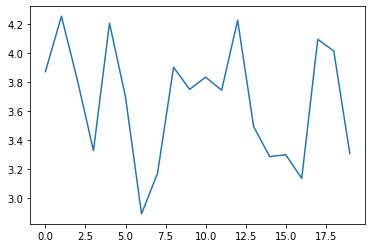

In [25]:
plt.plot(range(len(train_classic_performance['loss'])), train_classic_performance['loss'])

# dissect

In [19]:
batch = train.sample(args['batch_size'])

In [20]:
batch

,InChIKey,SMILES,uniprot+pfam,ic_value,ic_str,sentence_len,log(ic),BEL-level
2125,KNPRYLFUIRHVFZ-UHFFFAOYSA-N,COc1cc(F)c2nc(C)c3c(C)nc(-c4ccncc4C)n3c2c1,Q9Y233|PF00233,3.9,3.9,17,1.360977,3
20417,XLVQVCOZHAPLOB-NQERJWCQSA-N,Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N1Cc2ccccc2C[C@H]...,P97266|PF00001,4740.0,4740.0,6,8.463792,6
16058,AJUFRGDVXUPOOW-UHFFFAOYSA-N,CC(C)N1CCC(Oc2ccc3c(c2)cc2n3CCNC2=O)CC1,P08684|PF00067,50000.0,50000.0,17,10.819778,6
9579,YLFJVEHAPQRFDF-UHFFFAOYSA-N,CCc1nc2ccc(N(Cc3ccccc3Cl)C(=O)c3ccccc3)cc2c(=O...,P34976|PF00001,410.0,410.0,18,6.016157,5
5868,HLNUKOUNRKYWML-UHFFFAOYSA-N,Cc1cnc2[nH]cc(Cc3ccc(NCc4cnccc4C(F)(F)F)nc3F)c2c1,P33261|PF00067,5000.0,5000.0,6,8.517193,6
11587,GIZXRMWLDSGMSU-UHFFFAOYSA-N,N#Cc1nc(C(=O)NCC2(C(=O)O)CCS(=O)(=O)CC2)c(O)c2...,Q9GZT9|PF13640,37280.0,37280.0,17,10.526212,6


In [26]:
chem_graph,protein_tokenized = get_repr_DTI(batch,tokenizer,chem_dict,protein_dict,'DISAE')

In [72]:
chem_graph.to('cuda')

Batch(batch=[194], edge_attr=[428, 2], edge_index=[2, 428], x=[194, 6])

In [73]:
logit = model(protein_tokenized.to('cuda'),chem_graph.to('cuda'))

In [74]:
logit.shape

torch.Size([6, 26])

In [36]:
label = transform(batch['BEL-level'].values)

In [39]:
level = torch.tensor(batch['BEL-level'].values)

In [40]:
level

tensor([3, 6, 6, 5, 6, 6])

In [60]:
outp = result_transform.convert_continuous(logit.to('cuda'))

In [75]:
loss= criterion(outp.cpu(),level)

In [66]:
result_transform(logit.to('cuda'))

tensor([13., 21., 16., 25., 10.,  0.])

In [67]:
loss_fn = torch.nn.CrossEntropyLoss()

In [78]:
loss_fn(logit.cpu(),level)

tensor(3.9285, grad_fn=<NllLossBackward>)